In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

In [35]:
lafd = pd.read_csv('./data/new_lafd_census_raw_metrics.csv', index_col=0)
print(lafd.shape)
lafd.head()

/Users/jameslee/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(2988007, 29)


,dispatch_sequence,dispatch_status,first_in_district,ppe_level,randomized_incident_number,unit_type,nc_name,total_pop,white_pop,black_pop,...,time_of_dispatch_secs,en_route_time_secs,on_scene_time_secs,call_process_time,turnout_time,travel_time,response_time,year,quarter,regions
0,1,QTR,10,EMS,201301588315,RA - ALS RESCUE AMBULANCE,DOWNTOWN LOS ANGELES,40227.20,10689.28,6915.39,...,28941,29065,29310,77,124,245,369,2013,1,downtown
1,2,QTR,52,EMS,201301588315,E - ENGINE,HOLLYWOOD STUDIO DISTRICT NC,28142.56,5780.05,1291.89,...,28980,29070,29281,124,90,211,301,2013,1,hollywood
2,3,QTR,52,EMS,201301588315,RA - ALS RESCUE AMBULANCE,HOLLYWOOD STUDIO DISTRICT NC,28142.56,5780.05,1291.89,...,28980,29052,29309,124,72,257,329,2013,1,hollywood
3,1,QTR,29,EMS,201301588316,RA - ALS RESCUE AMBULANCE,GREATER WILSHIRE NC,50090.79,17032.14,2313.59,...,28978,29051,29331,78,73,280,353,2013,1,central
4,2,QTR,29,EMS,201301588316,RA8XX - BLS RESCUE AMBULANCE,GREATER WILSHIRE NC,50090.79,17032.14,2313.59,...,28978,29068,29973,78,90,905,995,2013,1,central


In [36]:
lafd.columns

Index(['dispatch_sequence', 'dispatch_status', 'first_in_district',
       'ppe_level', 'randomized_incident_number', 'unit_type', 'nc_name',
       'total_pop', 'white_pop', 'black_pop', 'ameri_es_pop', 'asian_pop',
       'hawn_pi_pop', 'other_pop', 'multi_pop', 'in_poverty', 'owner_occ',
       'renter_occ', 'incident_creation_time_secs', 'time_of_dispatch_secs',
       'en_route_time_secs', 'on_scene_time_secs', 'call_process_time',
       'turnout_time', 'travel_time', 'response_time', 'year', 'quarter',
       'regions'],
      dtype='object')

In [37]:
lafd.shape

(2988007, 29)

In [38]:
lafd['year'] =lafd['year'].astype('str')

lafd.drop(columns=['dispatch_sequence', 'randomized_incident_number',
                   'incident_creation_time_secs', 'time_of_dispatch_secs', 
                   'en_route_time_secs', 'on_scene_time_secs',
                   'travel_time'], inplace=True)


lafd.drop(lafd[lafd['year'] == '2013'].index, 0, inplace=True)
lafd.drop(lafd[lafd['year'] == '2014'].index, 0, inplace=True)
lafd.drop(lafd[lafd['year'] == '2015'].index, 0, inplace=True)

lafd['year'] = lafd['year'].astype('int')
lafd['quarter'] = lafd['quarter'].astype('str')

In [39]:
lafd.shape

(1255785, 22)

In [40]:
lafd.isnull().sum().sum()

0

In [41]:
lafd.dtypes

dispatch_status       object
first_in_district      int64
ppe_level             object
unit_type             object
nc_name               object
total_pop            float64
white_pop            float64
black_pop            float64
ameri_es_pop         float64
asian_pop            float64
hawn_pi_pop          float64
other_pop            float64
multi_pop            float64
in_poverty           float64
owner_occ            float64
renter_occ           float64
call_process_time      int64
turnout_time           int64
response_time          int64
year                   int64
quarter               object
regions               object
dtype: object

In [42]:
def population_perc(df, column, pop):
    return (df[column]/ df[pop]) * 100

In [43]:
lafd['white_perc'] = population_perc(lafd, 'white_pop', 'total_pop')
lafd['black_perc'] = population_perc(lafd, 'black_pop', 'total_pop')
lafd['ameri_es_perc'] = population_perc(lafd, 'ameri_es_pop', 'total_pop')
lafd['asian_perc'] = population_perc(lafd, 'asian_pop', 'total_pop')
lafd['hawn_pi_perc'] = population_perc(lafd, 'hawn_pi_pop', 'total_pop')
lafd['other_perc'] = population_perc(lafd, 'other_pop', 'total_pop')
lafd['multi_perc'] = population_perc(lafd, 'multi_pop', 'total_pop')
lafd['poverty_perc'] = population_perc(lafd, 'in_poverty', 'total_pop')
lafd['owner_occ_perc'] = population_perc(lafd, 'owner_occ', 'total_pop')
lafd['renter_occ_perc'] = population_perc(lafd, 'renter_occ', 'total_pop')

lafd.drop(columns=['white_pop', 'black_pop', 'ameri_es_pop', 'asian_pop', 'hawn_pi_pop', 'other_pop',
                  'multi_pop', 'in_poverty', 'owner_occ', 'renter_occ'], inplace=True)

In [44]:
lafd.head()

,dispatch_status,first_in_district,ppe_level,unit_type,nc_name,total_pop,call_process_time,turnout_time,response_time,year,...,white_perc,black_perc,ameri_es_perc,asian_perc,hawn_pi_perc,other_perc,multi_perc,poverty_perc,owner_occ_perc,renter_occ_perc
1747427,QTR,103,EMS,E - ENGINE,NORTHRIDGE SOUTH NC,32525.30,41,67,383,2016,...,34.738773,5.923912,0.016664,12.445881,0.238491,0.272588,2.194630,99.670687,16.278190,16.200435
1747428,QTR,103,EMS,RA - ALS RESCUE AMBULANCE,NORTHRIDGE SOUTH NC,32525.30,41,66,391,2016,...,34.738773,5.923912,0.016664,12.445881,0.238491,0.272588,2.194630,99.670687,16.278190,16.200435
1747429,QTR,7,EMS,E - ENGINE,ARLETA NC,34932.84,40,48,407,2016,...,8.252034,1.172736,0.193629,11.626052,0.100078,0.107578,0.701489,99.335067,16.002907,6.183122
1747430,QTR,7,EMS,RA8XX - BLS RESCUE AMBULANCE,ARLETA NC,34932.84,40,84,461,2016,...,8.252034,1.172736,0.193629,11.626052,0.100078,0.107578,0.701489,99.335067,16.002907,6.183122
1747431,QTR,26,EMS,E - ENGINE,UNITED NEIGHBORHOODS OF THE HISTORIC ARLINGTON...,52784.01,101,107,272,2016,...,5.631099,26.304008,0.056911,7.036260,0.000000,0.788534,1.568316,98.335462,7.752708,23.813253


In [45]:
categorical_cols = lafd.select_dtypes(include=['object'])
categorical_cols.columns

Index(['dispatch_status', 'ppe_level', 'unit_type', 'nc_name', 'quarter',
       'regions'],
      dtype='object')

### Creating dummy variables for categorical features


In [46]:
lafd_dummies = pd.get_dummies(lafd, drop_first=True)

In [47]:
lafd_dummies.shape

(1255785, 107)

For whatever reason, there seems to be huge outliers. There are 7 instances where the time that the LAFD respondants arrived on the scene from the time the respondents dispatched is over 11 hours long! 

Seeing how all the top 5 instances are in different time-frames and in different locations, we will act as if this was an error on their part. As a result we will remove any observations with a response time that goes over 1 hour (3,600 seconds). 
We will also remove any observations where the response time is lower than 1 minute (60 seconds).

In [48]:
lafd_dummies['response_time'].sort_values(ascending=False).head()

1925441    45959
2202396    40162
2202399    40162
2202398    40162
2202397    40162
Name: response_time, dtype: int64

In [49]:
lafd.loc[1925441]

dispatch_status             QTR
first_in_district            98
ppe_level               Non-EMS
unit_type            E - ENGINE
nc_name              PACOIMA NC
total_pop                 69476
call_process_time            78
turnout_time                 25
response_time             45959
year                       2016
quarter                       2
regions               sf_valley
white_perc              2.24754
black_perc              4.75792
ameri_es_perc         0.0284991
asian_perc              1.75091
hawn_pi_perc          0.0193448
other_perc             0.105346
multi_perc             0.273058
poverty_perc            99.1251
owner_occ_perc          11.1089
renter_occ_perc         10.3766
Name: 1925441, dtype: object

In [50]:
lafd_dummies.drop(lafd_dummies[lafd_dummies['response_time'] < 60].index,0,inplace=True)
lafd_dummies.drop(lafd_dummies[lafd_dummies['response_time'] > 3600].index,0,inplace=True)

In [51]:
lafd_dummies['y_hat'] = lafd_dummies['response_time'].mean()

In [52]:
print(lafd_dummies['response_time'].mean())

373.1350614200295


In [53]:
def model_score(y_true,y_hat):
    
    RMSE = round(mean_squared_error(y_true , y_hat)**0.5, 3)
    R2 = round(r2_score(y_true,y_hat),3)
    
    print(f'Root Mean Squared Error: {RMSE} nR2: {R2}')

model_score(lafd_dummies['response_time'], lafd_dummies['y_hat'])

Root Mean Squared Error: 221.671 nR2: 0.0


In [54]:
lafd_dummies.drop('y_hat',1,inplace=True)

All models will be scored according to the two metrics above. RMSE and R2 scores the model performance by examining the magnitiude of the model's residual errors (the difference between the actual response time to the mean response time. 

**Root Mean Squared Error:** RMSE is 233.9, which is quite large given our dataset. This metric represents the average distance from the actual response time to the predicted response time (mean). We need to minimize this score in order to have an accurate model.

**R2 score:** The baseline model does not explain any of the target data's variability around its' mean. The predictions are inaccurate. The goal is to increase the R2 score as close to 1 (100%) as possible so that the variability in the data can be explained by the model.

In [55]:
lafd_dummies.to_csv('./data/lafd_dummies.csv')

In [56]:
lafd_dummies['logy'] = lafd_dummies['response_time'].apply(np.log)

In [57]:
X = lafd_dummies.drop(columns=['response_time', 'logy'])
y = lafd_dummies['logy']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    random_state= 42, 
                                                    test_size = 0.3);


ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

/Users/jameslee/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jameslee/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/jameslee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [58]:
lr = LinearRegression()
lr.fit(X_train_sc, y_train)


R2_train = lr.score(X_train_sc, y_train)
R2_test = lr.score(X_test_sc, y_test)
   
y_hat = lr.predict(X_test_sc)

print(f'Train R2 Score: {R2_train}')
print(f'Test R2 Score: {R2_test}')

Train R2 Score: 0.16100812885771
Test R2 Score: 0.15931963671763205


In [59]:
pd.DataFrame(lr.coef_, index = X.columns, columns = ['estimated_Coefs']).head(10)

,estimated_Coefs
first_in_district,3.050013e-03
total_pop,1.306287e+11
call_process_time,2.827221e-02
turnout_time,9.624688e-02
year,2.440997e-02
white_perc,-8.629987e+10
black_perc,2.478130e+11
ameri_es_perc,7.793821e+10
asian_perc,5.426175e+11
hawn_pi_perc,-1.257267e+11


In [60]:
betas_lr_sc = pd.DataFrame(lr.coef_, X.columns)

betas_lr_sc.columns = ['weights']

betas_lr_sc['abs_weights'] = betas_lr_sc.weights.abs()

betas_0_lr_sc = lr.intercept_

weights_lr_sc = betas_lr_sc.sort_values('abs_weights', ascending=False)['weights'].head(10)

labels_lr_sc = weights_lr_sc.index

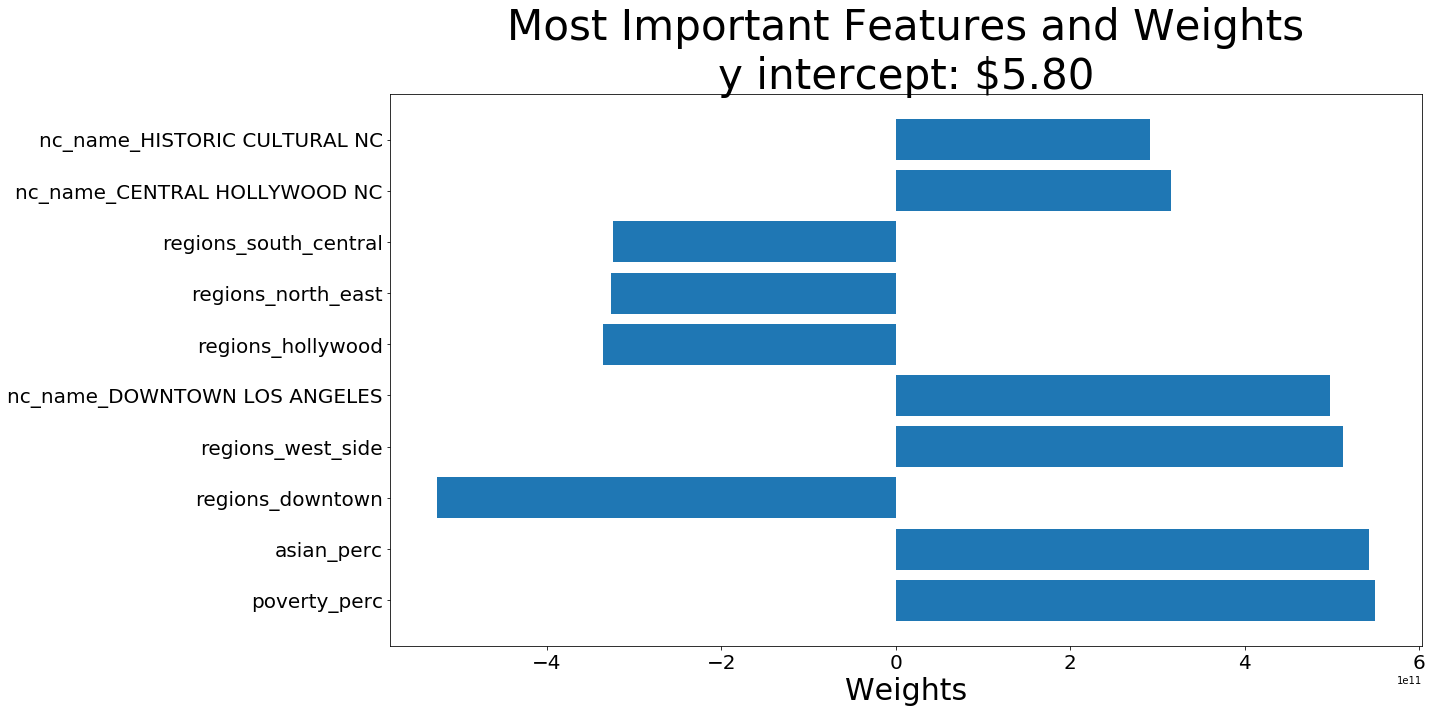

In [61]:
plt.figure(figsize=(20,10))
plt.barh(labels_lr_sc, weights_lr_sc)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title(f'Most Important Features and Weights\ny intercept: ${betas_0_lr_sc:0.02f}', fontsize=42)  
#0.02 is telling me i want 2 float decimal format
plt.tight_layout()

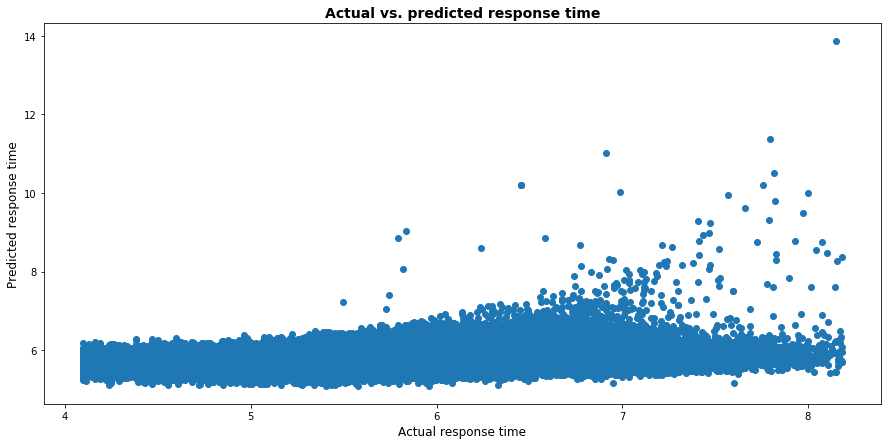

In [62]:

fig = plt.figure(figsize=(15, 7))

#Plot actual vs. predicted on response time

plt.scatter(y_test, y_hat);
# plt.xlim([0,50]);
# plt.ylim([0,50]);
plt.xlabel('Actual response time', fontsize = 12);
plt.ylabel('Predicted response time', fontsize = 12);
plt.title('Actual vs. predicted response time', fontsize = 14, fontweight = 'bold');

In [251]:
r_alphas = np.logspace(0, 5, 100)
ridge_cv = RidgeCV(alphas = r_alphas, cv = 3)
ridge_cv.fit(X_train_sc, y_train)
   
R2_train = ridge_cv.score(X_train_sc, y_train)
R2_test = ridge_cv.score(X_test_sc, y_test)

print(f'Train R2 Score: {R2_train}')
print(f'Test R2 Score: {R2_test}')

Train R2 Score: 0.122785794956501
Test R2 Score: 0.12188903307413912


In [64]:
lasso_cv = LassoCV(cv = 5)
lasso_cv.fit(X_train_sc, y_train)
   
R2_train = lasso_cv.score(X_train_sc, y_train)
R2_test = lasso_cv.score(X_test_sc, y_test)
   
y_hat_lasso = lasso_cv.predict(X_test_sc)

print(f'Train R2 Score: {R2_train}')
print(f'Test R2 Score: {R2_test}')



Train R2 Score: 0.16104012450340932
Test R2 Score: 0.15934456046791368
